In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score,recall_score,precision_score
from tqdm.notebook import tqdm
from tqdm import tqdm

In [3]:
#Model Parameters
batch_size = 64
learning_rate = 1e-4
Num_Epochs= 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#Download Data and Dataloader
transform = transforms.Compose(
    [transforms.ToTensor()])

Train_Data = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
Train_Loader = torch.utils.data.DataLoader(Train_Data, batch_size=batch_size,shuffle=True)

Test_Data = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)
Test_Loader = torch.utils.data.DataLoader(Test_Data, batch_size=batch_size,shuffle=False)

Train_Length = Train_Data.data.shape[0]
Test_Length = Test_Data.data.shape[0]
# Train_Length = 50
# Test_Length = 10
print("Training Shape: ",Train_Data.data.shape)
print("Training Shape: ", Test_Data.data.shape)


Training Shape:  torch.Size([60000, 28, 28])
Training Shape:  torch.Size([10000, 28, 28])


In [5]:
#Model Architecture
class CNN_Module(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=(1,1))
        self.pool1=nn.MaxPool2d(2,2)
        self.pool2=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1))
        self.fc1=nn.Linear(1024,1024)
        self.fc2=nn.Linear(1024,10)
        
        self.relu1=nn.ReLU()
        self.relu2=nn.ReLU()
        self.relu3=nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x   

In [6]:

cnn = CNN_Module().to(device)
CE_Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [7]:
training_loss_per_epoch=[]
training_accuracy_per_epoch=[]

testing_loss_per_epoch=[]
testing_accuracy_per_epoch=[]

f1_score_array=[]
recall_score_array=[]
precision_score_array=[]

counter = -1
for epoch in tqdm(range(Num_Epochs)):
    pool1_list, pool2_list = [], []
    train_loss = 0
    train_accuracy = 0
    
    test_loss = 0
    test_accuracy = 0

    epochtrainloss = []
    epochtestloss = []
    for i, data in enumerate(Train_Loader):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
    
        outputs = cnn(inputs)

        loss = CE_Loss(outputs, labels)
        
        _, predicted = torch.max(outputs.data,1)
        train_accuracy += torch.sum(predicted==labels).item()
        
        epochtrainloss.append(loss.item())
        loss.backward()
        optimizer.step()


        # print(activation['pool1'])
        # print(activation['pool2'])
    scheduler.step()
    training_loss_per_epoch.append(np.mean(epochtrainloss))
    train_accuracy = train_accuracy/Train_Length
    training_accuracy_per_epoch.append(train_accuracy)
    cnn.eval()
    pred = []
    tar = []
    for i, data in enumerate(Test_Loader):
        inputs,labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)

        outputs = cnn(inputs)

        Testing_loss= CE_Loss(outputs, labels)
        _, predicted = torch.max(outputs.data,1)
        test_accuracy += torch.sum(predicted==labels).item()
        epochtestloss.append(Testing_loss.item())
        pred.extend(predicted.detach().cpu().numpy())
        tar.extend(labels.detach().cpu().numpy())

    
    f1_score_array.append(f1_score(tar,pred,average='weighted'))
    recall_score_array.append(recall_score(tar,pred,average='weighted'))
    precision_score_array.append(precision_score(tar,pred,average='weighted'))
    
    testing_loss_per_epoch.append(np.mean(epochtestloss))
    test_accuracy = test_accuracy/Test_Length
    testing_accuracy_per_epoch.append(test_accuracy)
    

100%|██████████| 50/50 [05:33<00:00,  6.68s/it]


In [8]:
print("Final Train Accuracy: ", training_accuracy_per_epoch[-1])
print("Final Train Loss: ", training_loss_per_epoch[-1])

print("Final Test Accuracy: ", testing_accuracy_per_epoch[-1])
print("Final Test Loss: ", testing_loss_per_epoch[-1])

Final Train Accuracy:  0.9939666666666667
Final Train Loss:  1.4684173887980772
Final Test Accuracy:  0.9888
Final Test Loss:  1.4729702996600205


In [9]:
# Number of convolution layers
model_weights = []
conv_layers = [] 
model_children = list(cnn.children())
counter = 0 
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [10]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([32, 1, 3, 3])
CONV: Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 5, 5])


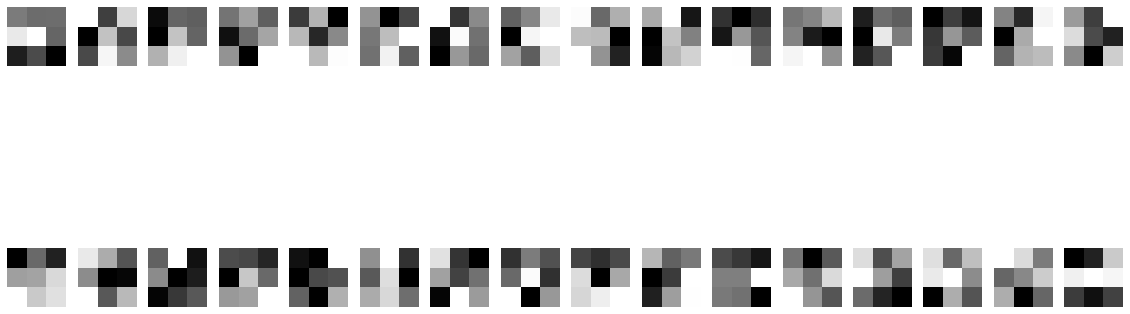

In [11]:
# Kernel filter
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 16, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='binary')
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

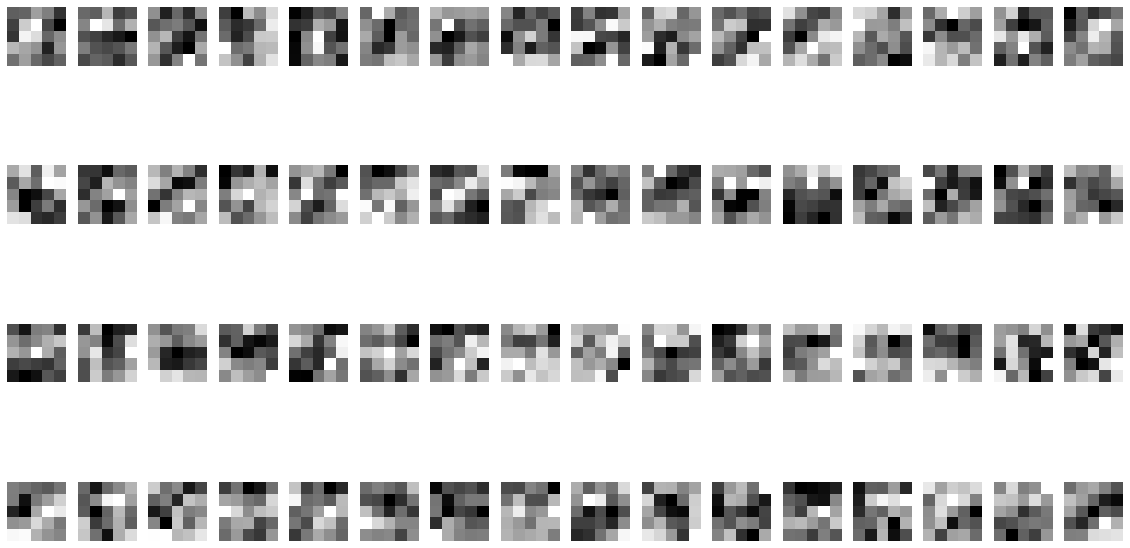

In [12]:
# Kernel filter
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(6, 16, i+1) # (8, 8) because in conv0 we have 5x5 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='binary')
    plt.axis('off')
    plt.savefig('filter2.png')
plt.show()

In [20]:
#Activation Map of the second convolution layer
activation = {}
def getActivation(name):
  # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

h1 = cnn.conv1.register_forward_hook(getActivation('conv1'))
h2 = cnn.conv2.register_forward_hook(getActivation('conv2'))

data, _ = Train_Data[4]
data=data.to(device)
data.unsqueeze_(0)
output = cnn(data)

k=0
act = activation['conv1'].squeeze()
# print(act.size())
# print(act.size(0)//8," ",act.size(0)//16)
fig,ax = plt.subplots(4,4,figsize=(12, 15))

# print(act[0].detach().cpu().numpy())

for i in range(4):
        # print(i)
        for j in range(4):
          #  print(j)
           ax[i,j].imshow(act[k].detach().cpu().numpy(),cmap='binary')
           k+=1
           plt.savefig('fm1.png')
plt.show()

ValueError: only one element tensors can be converted to Python scalars

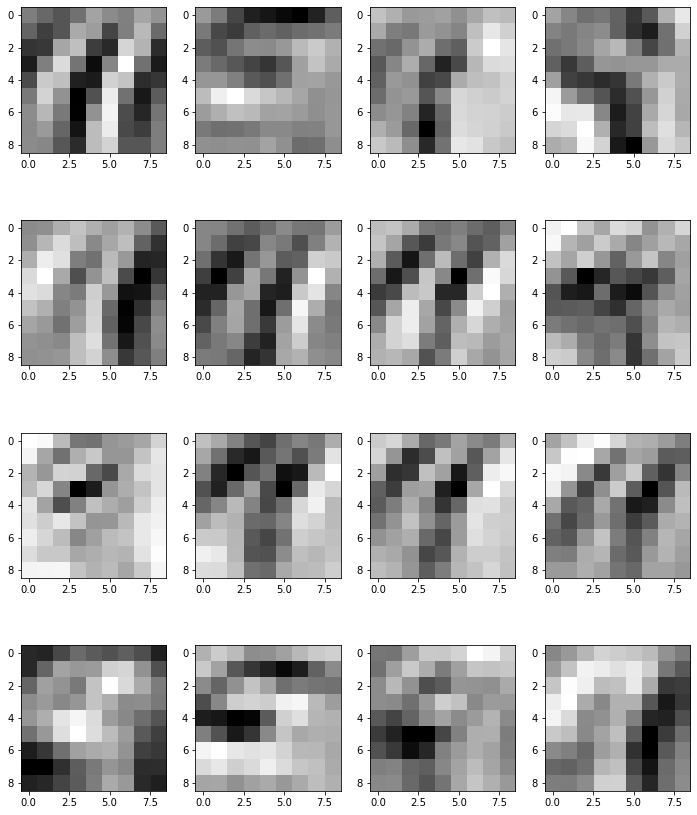

In [14]:
k=0
act = activation['conv2'].squeeze()
# print(act.size())
# print(act.size(0)//8," ",act.size(0)//16)
fig,ax = plt.subplots(4,4,figsize=(12, 15))

# print(act[0].detach().cpu().numpy())

for i in range(4):
        # print(i)
        for j in range(4):
          #  print(j)
           ax[i,j].imshow(act[k].detach().cpu().numpy(),cmap='binary')
           k+=1
           plt.savefig('fm2.png')
plt.show()

Train Accuracy: 0.9939666666666667
Test Accuracy: 0.9888


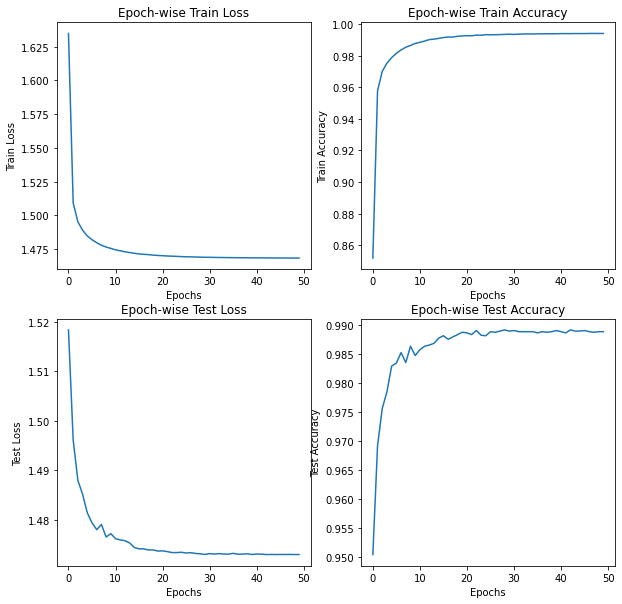

In [15]:
import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("Epoch-wise Train Loss")
plt.plot(training_loss_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Train Loss', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,2)
plt.title("Epoch-wise Train Accuracy")
plt.plot(training_accuracy_per_epoch)
print("Train Accuracy:",(training_accuracy_per_epoch[-1]) )
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Train Accuracy', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,3)
plt.title("Epoch-wise Test Loss")
plt.plot(testing_loss_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Test Loss', fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,4)
plt.title("Epoch-wise Test Accuracy")
plt.plot(testing_accuracy_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Test Accuracy', fontsize=10)
print("Test Accuracy:",(testing_accuracy_per_epoch[-1]) )

F1 SCORE: 0.9887984007784835
Precision: 0.9888340180997857
Recall: 0.9888


Text(0, 0.5, 'Recall')

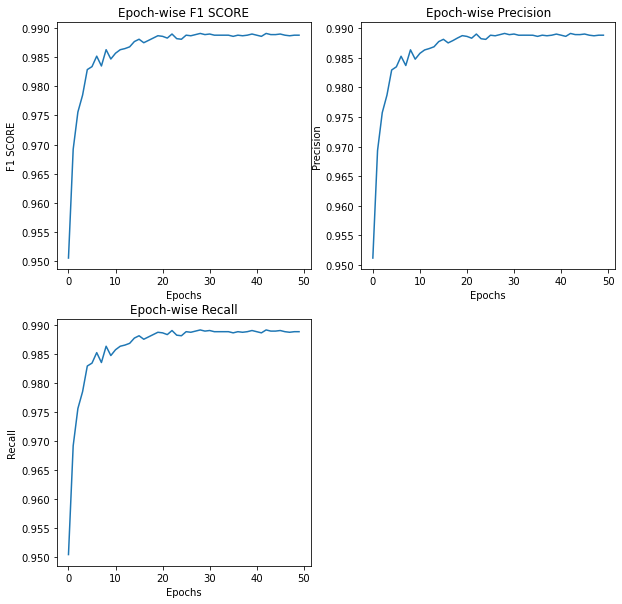

In [16]:
#Epochwise Score Metrics
fig1 = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(f1_score_array)
print("F1 SCORE:",(f1_score_array[-1]) )
plt.title("Epoch-wise F1 SCORE")
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('F1 SCORE', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,2)
plt.plot(precision_score_array)
print("Precision:",(precision_score_array[-1]) )
plt.title("Epoch-wise Precision")
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Precision', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,3)
print("Recall:",(recall_score_array[-1]) )
plt.title("Epoch-wise Recall")
plt.plot(recall_score_array)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Recall', fontsize=10)

# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)



Train Accuracy: 0.9939666666666667


Text(0, 0.5, 'Accuracy')

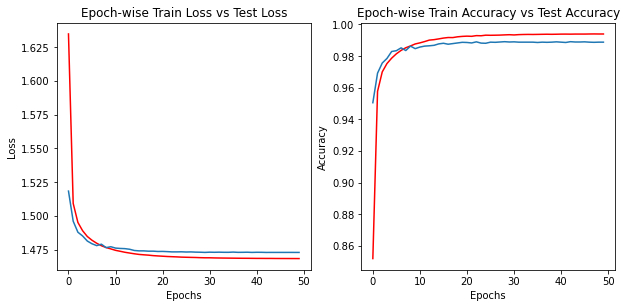

In [17]:
#Accuracy amd Loss comparisions
fig1 = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("Epoch-wise Train Loss vs Test Loss")
plt.plot(training_loss_per_epoch, color ='red')
plt.plot(testing_loss_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,2)
plt.title("Epoch-wise Train Accuracy vs Test Accuracy")
plt.plot(training_accuracy_per_epoch, color ='red')
plt.plot(testing_accuracy_per_epoch)
print("Train Accuracy:",(training_accuracy_per_epoch[-1]) )
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)

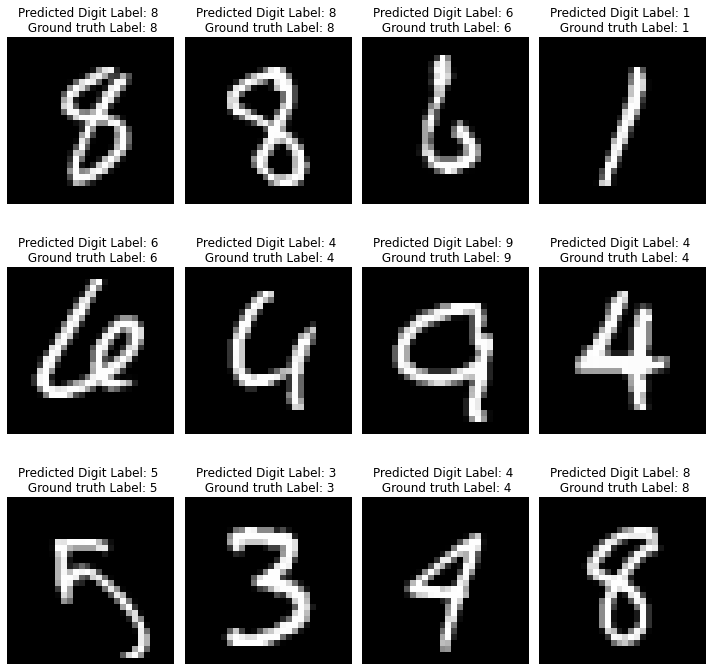

In [18]:
# Plot ten samples with prediction
data = next(iter(Train_Loader))
inputs, labels = data[0:10]
inputs=inputs.to(device)
labels=labels.to(device)
outputs = cnn(inputs)
_, predicted = torch.max(outputs.data,1)
# print(predicted)
# print(labels)

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,10))

i = 0
for ax in axs.reshape(-1):
    ax.set_title("Predicted Digit Label: %d \n Ground truth Label: %d" % (predicted[i] , labels[i]))
    ax.imshow(np.squeeze(inputs.cpu().numpy())[i], cmap=plt.cm.gray, origin='upper', interpolation='nearest')

    ax.axis('off')
    i += 1
plt.tight_layout()   
plt.show()